# Imports

In [56]:
# imports, including functions provided with the starter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from numpy.random import seed
import statsmodels.api as sm

if 'notebooks' in os.getcwd():
    os.chdir('..')

from groupXY_functions import *


# Defining functions and preprocessing

In [2]:
# Return smallest and largest x, smallest and largest y that contains a white pixel, so that we can crop it to measure asymmetry
def get_extremes(image):
    non_zeros = np.nonzero(image)
    return min(non_zeros[1]), max(non_zeros[1]), min(non_zeros[0]), max(non_zeros[0])

In [3]:
# Crops both the image and the mask to the actual size of the mask, saves to files
# Returns cropped image and mask in the array
def crop(image_id):
    path = 'data/example_image'
    path_cropped = path + '_cropped'
    path_mask = 'data/example_segmentation'
    path_mask_cropped = path_mask + '_cropped'
    if os.path.exists(path_cropped + image_id + '.jpg'):
        image = plt.imread(path_cropped + '/' + image_id + '.jpg')
        mask = plt.imread(path_mask_cropped + '/' + image_id + '.png')
        return image, mask
    if not os.path.exists(path_cropped):
        os.mkdir(path_cropped)
        os.mkdir(path_mask_cropped)
    image = plt.imread(path + '/' + image_id + '.jpg')
    mask = plt.imread(path_mask + '/' + image_id + '_segmentation.png')
    min_x, max_x, min_y, max_y = get_extremes(mask)
    mask = mask[min_y:max_y+1, min_x:max_x+1]
    plt.imsave(path_mask_cropped + '/' + image_id + '.png', mask, cmap=plt.cm.gray)
    image_cropped = image.copy()[min_y:max_y+1, min_x:max_x+1, :]
    to_black = mask==0
    image_cropped[to_black] = (0,0,0)
    plt.imsave(path_cropped + '/' + image_id + '.jpg', image_cropped)   
    return image, mask

In [4]:
# Assymetry function
# 0 is a perfect circle, 1 has all the quarters of an image completely different
def asymmetry_score(image):

    height, width = np.shape(image)
    if width % 2:
        # Subparts need to be the same size to compare them
        left_half = image[:, 0:width//2+1]
    else:
        left_half = image[:, 0:width//2]
    # "folding" on vertical axis
    right_half = np.flip(image[:, width//2:], 1)
    
    if height % 2:
        top_half = image[0:height//2+1, :]
    else:
        top_half = image[0:height//2, :]
    # "folding" on hotizontal axis
    bottom_half = np.flip(image[height//2:, :], 0)
    
    hor_diff = np.where(left_half != right_half, 1, 0)
    ver_diff = np.where(top_half != bottom_half, 1, 0)
    return round((np.sum(hor_diff) + np.sum(ver_diff)) / (width * height),3)

In [5]:
# Border function, compactness
# Due to inherit limitations of digital images, for some masks returend compactness value is below 1, which is wrong.
# Nonetheless, such an imprecission is acceptable given that multiple variables are considred in diagnoses 
def get_compactness(area, perimeter):
    return round(perimeter**2 / (4 * np.pi * area),3)

In [6]:
def colour_extraction (cropped_image):
    
    # split the image into its respective RGB components
    r, g, b = np.array_split(cropped_image, 3, 2)
    
    return r,g,b

def colour_variance_avg(r,g,b):
    return np.mean((np.var(r[r>0]),np.var(g[g>0]),np.var(b[b>0])))

In [7]:
# Import a data frame with file names and associated diseases
df_conditions = pd.read_csv('data/example_ground_truth.csv')

# A new data frame is created, which will store results of ABC tests 
df_evaluations = pd.DataFrame(df_conditions['image_id'])
for name in ['asymmetry', 'border', 'colour']:
    df_evaluations[name] = 0.0
    
for i in range(df_evaluations.shape[0]):
    image, mask = crop(df_evaluations.at[i, 'image_id'])
    df_evaluations.at[i, 'asymmetry'] = asymmetry_score(mask)
    area, perimeter = measure_area_perimeter(mask)
    df_evaluations.at[i, 'border'] = get_compactness(area, perimeter)
    r,g,b = colour_extraction(image)
    df_evaluations.at[i,'colour'] = colour_variance_avg(r,g,b)

# Standarisation of features' values

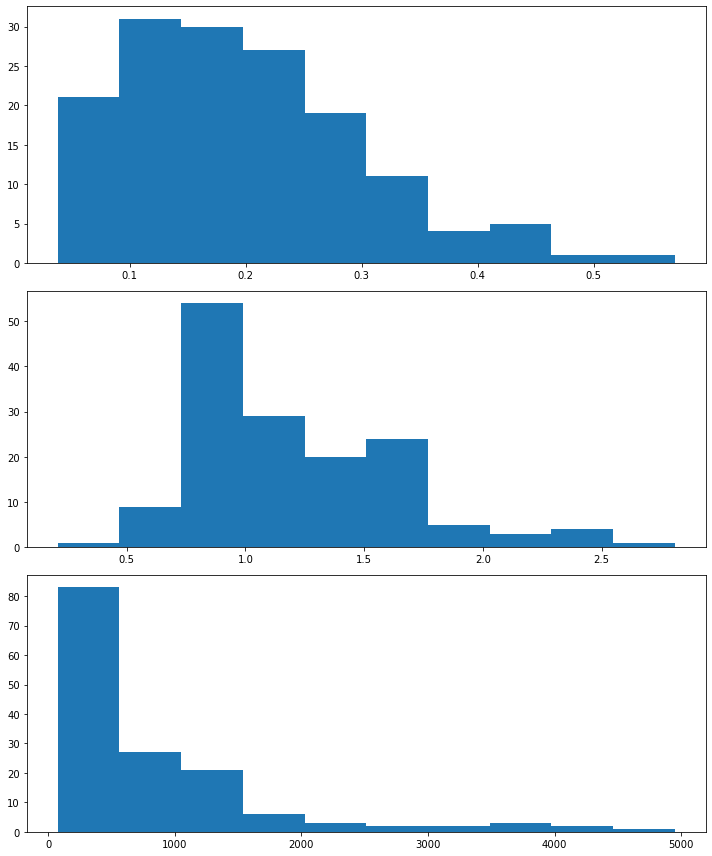

In [8]:
#data before standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()


In [9]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,0.195,1.458,618.627600
1,ISIC_0001852,0.126,0.984,447.253504
2,ISIC_0001871,0.259,0.999,1623.115145
3,ISIC_0003462,0.060,0.743,1412.217843
4,ISIC_0003539,0.416,1.058,306.096484
...,...,...,...,...
145,ISIC_0015443,0.099,1.180,1162.263646
146,ISIC_0015445,0.570,2.387,1805.319398
147,ISIC_0015483,0.072,1.445,1966.925779
148,ISIC_0015496,0.201,1.491,4029.559465


In [24]:
for name in ['asymmetry', 'border', 'colour']:
    mean = np.mean(df_evaluations[name])
    sd = np.std(df_evaluations[name])
    for i in range(df_evaluations.shape[0]):
        df_evaluations.at[i, name] = (df_evaluations.at[i, name] - mean) / sd

In [25]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,-0.023781,0.578983,-0.232156
1,ISIC_0001852,-0.709402,-0.476142,-0.420793
2,ISIC_0001871,0.612156,-0.442752,0.873516
3,ISIC_0003462,-1.365212,-1.012609,0.641374
4,ISIC_0003539,2.172190,-0.311418,-0.576170
...,...,...,...,...
145,ISIC_0015443,-0.977688,-0.039845,0.366242
146,ISIC_0015445,3.702415,2.646940,1.074074
147,ISIC_0015483,-1.245974,0.550045,1.251959
148,ISIC_0015496,0.035838,0.652441,3.522368


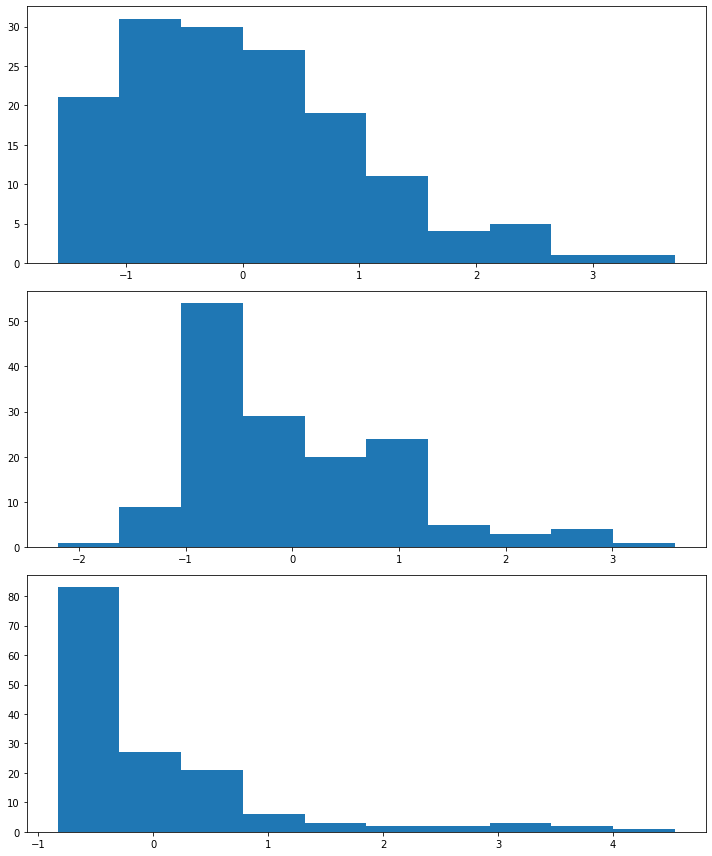

In [12]:
#data after standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()

In [13]:
##Loading data#

In [14]:
df = df_conditions.drop('seborrheic_keratosis', axis=1).merge(df_evaluations, on='image_id').drop('image_id', axis=1)
print(df.head())

   melanoma  asymmetry    border    colour
0       0.0  -0.023781  0.578983 -0.232156
1       0.0  -0.709402 -0.476142 -0.420793
2       0.0   0.612156 -0.442752  0.873516
3       0.0  -1.365212 -1.012609  0.641374
4       0.0   2.172190 -0.311418 -0.576170


In [15]:
# Split dataset to select feature and evaluate the classifier
X = df[['asymmetry', 'border', 'colour']]
y = df['melanoma']

# X_train and y_train used for training, X_val and y_val are for predicting and validating the ML model
X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.4, random_state=0)



In [16]:
# Train a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1trained = knn1.fit(X_train, y_train)

knn2 = KNeighborsClassifier(n_neighbors=9)
knn2trained = knn2.fit(X_train, y_train)


In [17]:
y_val_knn1 = knn1trained.predict(X_val)
y_val_knn2 = knn2trained.predict(X_val)

# Accuracy - often used in ML but not suitable for medical imaging in general
print(np.sum(y_val_knn1 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_knn2 == y_val) / np.size(y_val) * 100)


68.33333333333333
83.33333333333334


# Scatters

In [133]:
name = k[0:100]
asymmetry = name.loc[:,"Asymmetry"]
border = name.loc[:,"Border"]
Color = name.loc[:,"Color"]
Filename = name.loc[:,"Filename"]
Diagnosis= pd.read_csv("data/Diagnosis.csv")
Diag1 = Diagnosis[0:100]
melanoma = Diag1.loc[:,"melanoma"]
Diagnosis1 = pd.read_csv("data/Diagnosis.csv")
Diag2 = Diagnosis1.tail(100)
keratosis = Diag2.loc[:,"seborrheic_keratosis"]


df_evaluation= df_evaluations[0:100]

In [141]:
corrma = Diag1['melanoma'].corr(df_evaluation['asymmetry'])
corrbo = Diag1['melanoma'].corr(df_evaluation['border'])
corrco = Diag1['melanoma'].corr(df_evaluation['colour'])


In [142]:
x = Diagnosis["melanoma"].tolist()
y = df_evaluation["asymmetry"].tolist()

In [143]:
#MELANOMA AND ASYMMETRY 
est = sm.OLS(Diag1["melanoma"].tolist(),df_evaluation["asymmetry"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.007
Method:                 Least Squares   F-statistic:                             0.2562
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                       0.614
Time:                        22:07:49   Log-Likelihood:                         -58.728
No. Observations:                 100   AIC:                                      119.5
Df Residuals:                      99   BIC:                                      122.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [144]:
#MELANOMA AND BORDER
est = sm.OLS(Diag1["melanoma"].tolist(),df_evaluation["border"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              2.281
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                       0.134
Time:                        22:07:50   Log-Likelihood:                         -57.718
No. Observations:                 100   AIC:                                      117.4
Df Residuals:                      99   BIC:                                      120.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [145]:
#MELANOMA AND COLOUR ----- HERE WE CAN SEE THAT WE HAVE CORRELATION#
est = sm.OLS(Diag1["melanoma"].tolist(),df_evaluation["colour"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.084
Model:                            OLS   Adj. R-squared (uncentered):              0.075
Method:                 Least Squares   F-statistic:                              9.131
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                     0.00320
Time:                        22:07:51   Log-Likelihood:                         -54.446
No. Observations:                 100   AIC:                                      110.9
Df Residuals:                      99   BIC:                                      113.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [146]:
#KERATOSIS AND ASYMMETRY

est = sm.OLS(Diag2["seborrheic_keratosis"].tolist(),df_evaluation["asymmetry"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.020
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                       0.315
Time:                        22:07:51   Log-Likelihood:                         -72.066
No. Observations:                 100   AIC:                                      146.1
Df Residuals:                      99   BIC:                                      148.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [147]:
#KERATOSIS AND BORDER
est = sm.OLS(Diag2["seborrheic_keratosis"].tolist(),df_evaluation["border"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.1435
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                       0.706
Time:                        22:07:51   Log-Likelihood:                         -72.507
No. Observations:                 100   AIC:                                      147.0
Df Residuals:                      99   BIC:                                      149.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [148]:
#KERATOSIS AND COLOUR
est = sm.OLS(Diag2["seborrheic_keratosis"].tolist(),df_evaluation["colour"].tolist()).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.153
Model:                            OLS   Adj. R-squared (uncentered):              0.144
Method:                 Least Squares   F-statistic:                              17.83
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                    5.37e-05
Time:                        22:07:51   Log-Likelihood:                         -64.299
No. Observations:                 100   AIC:                                      130.6
Df Residuals:                      99   BIC:                                      133.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------